In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:367: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/690/database


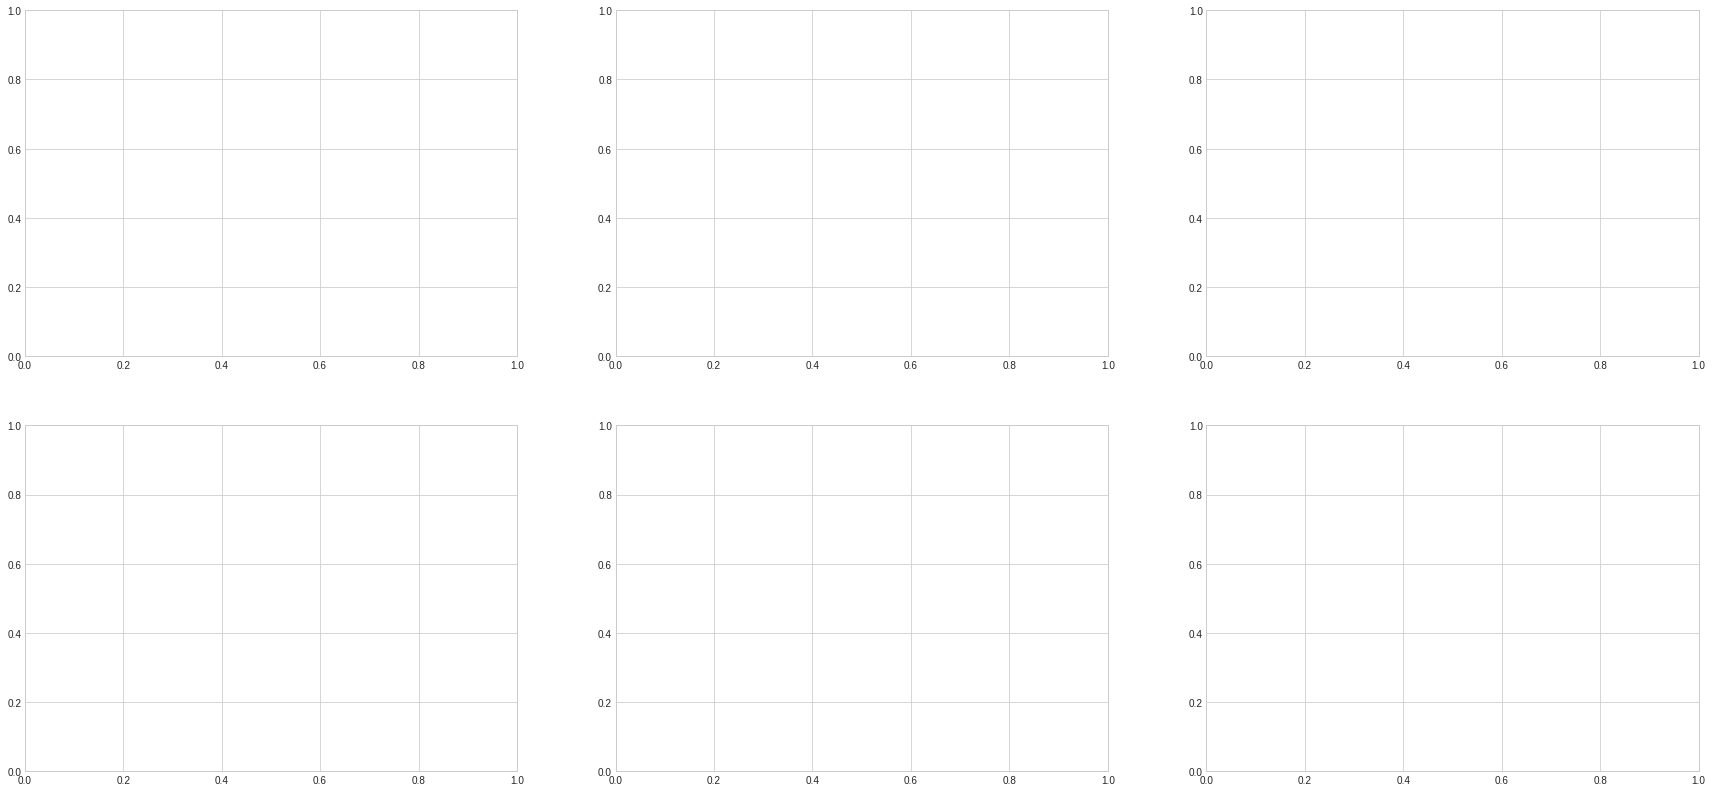

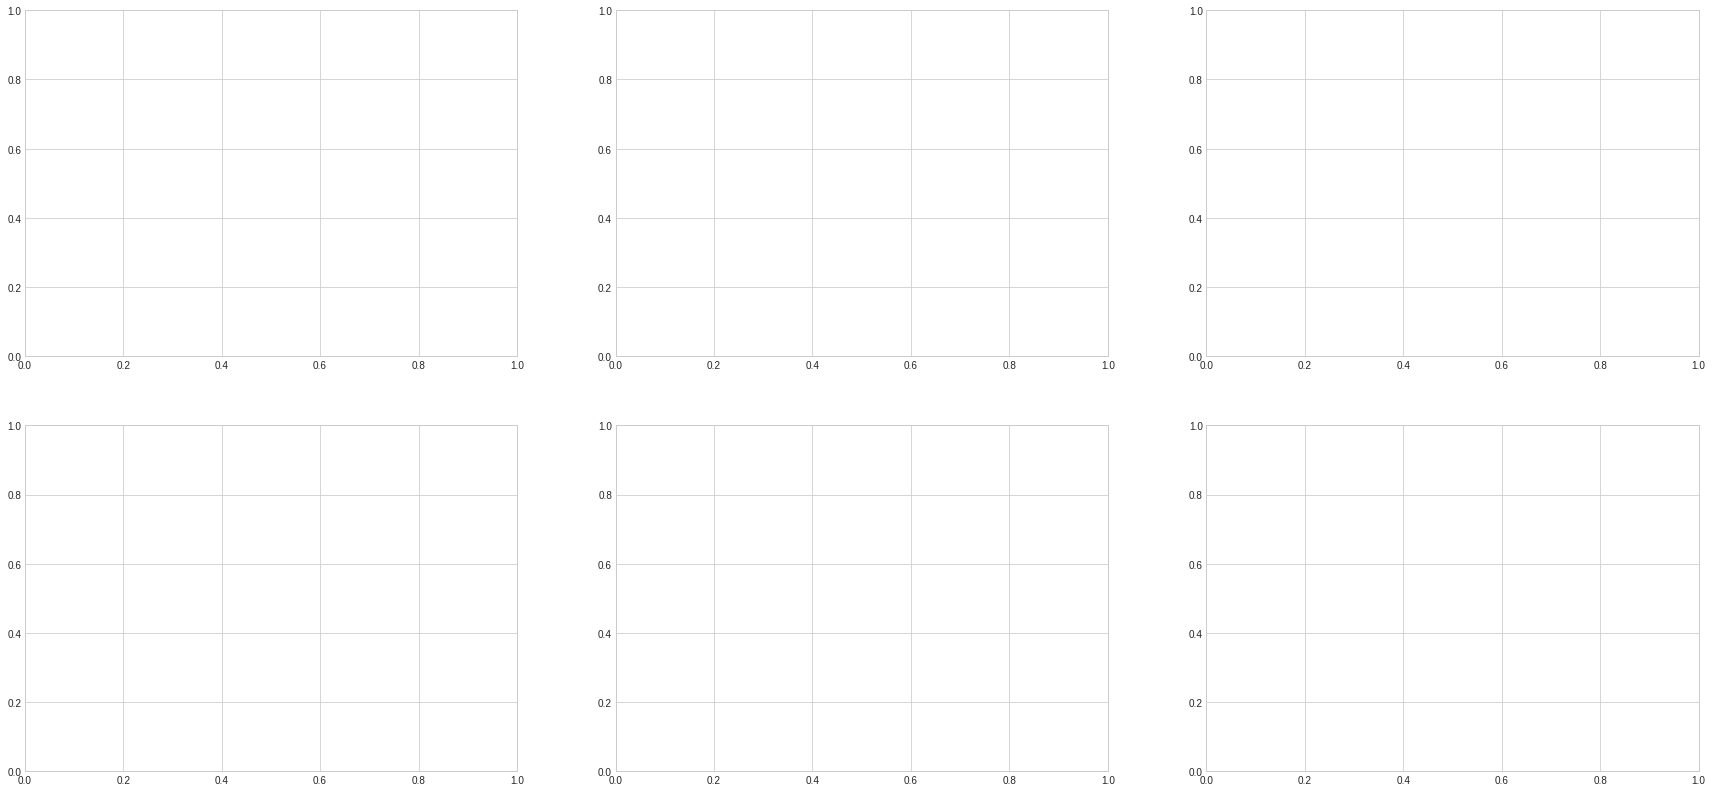

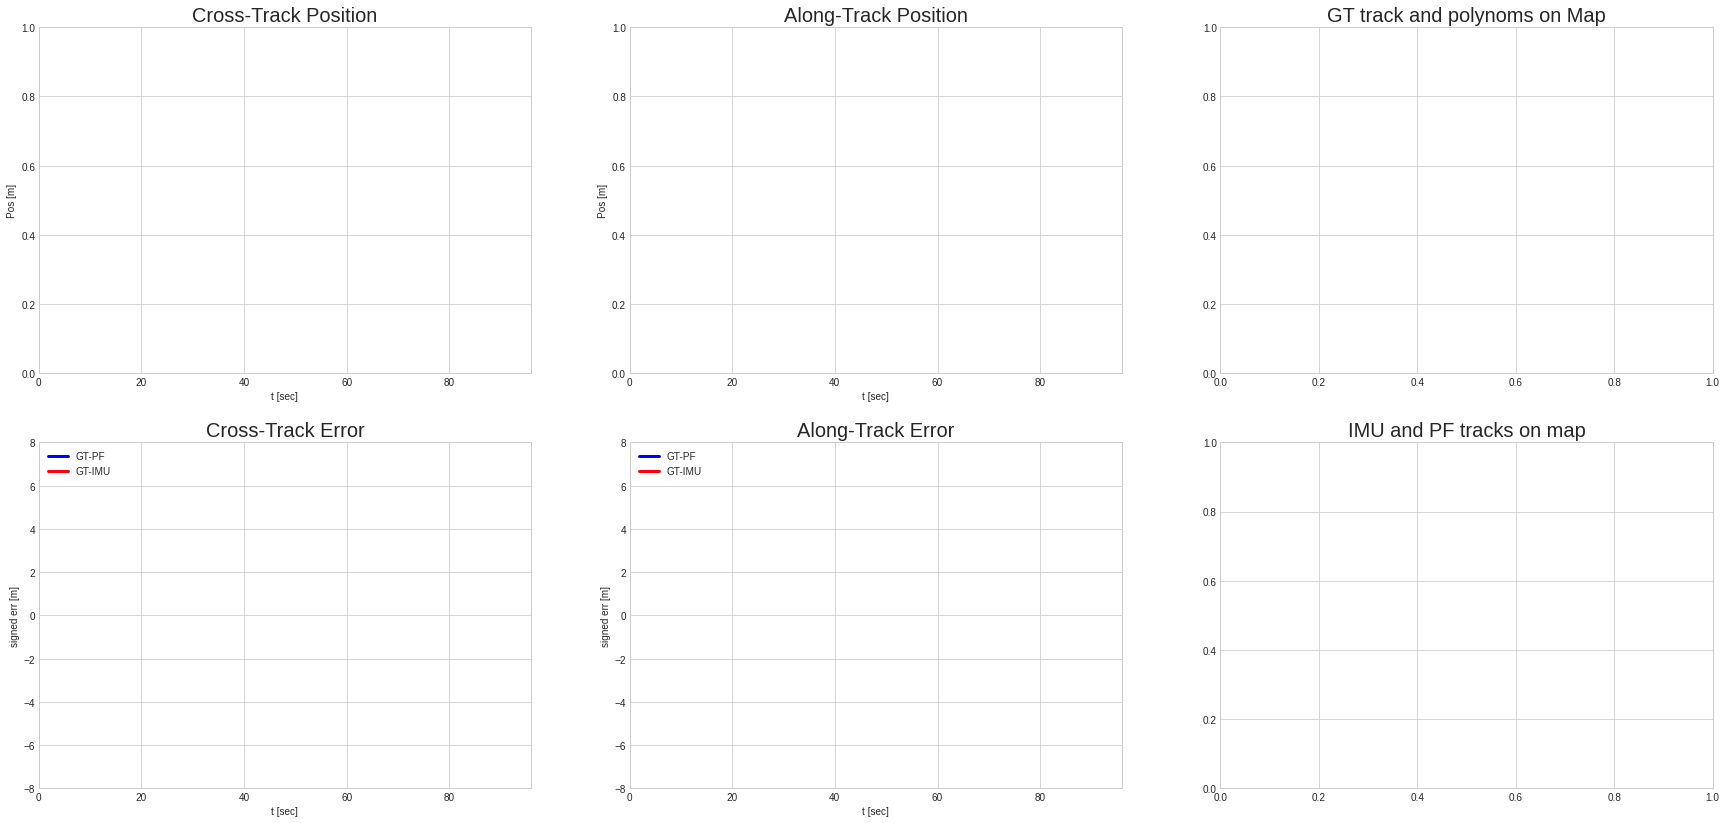

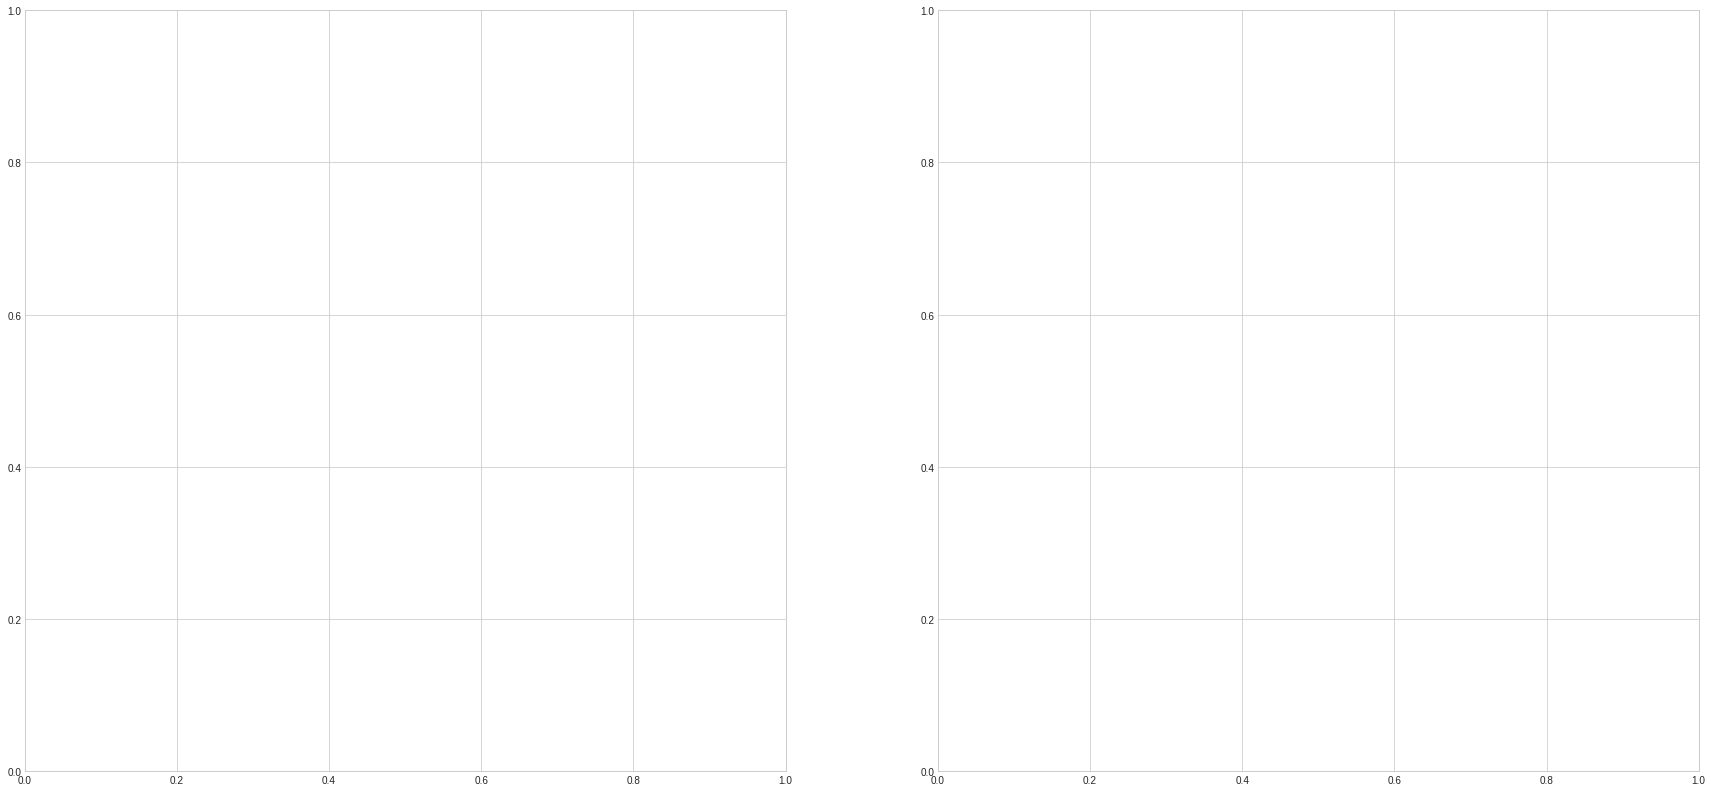

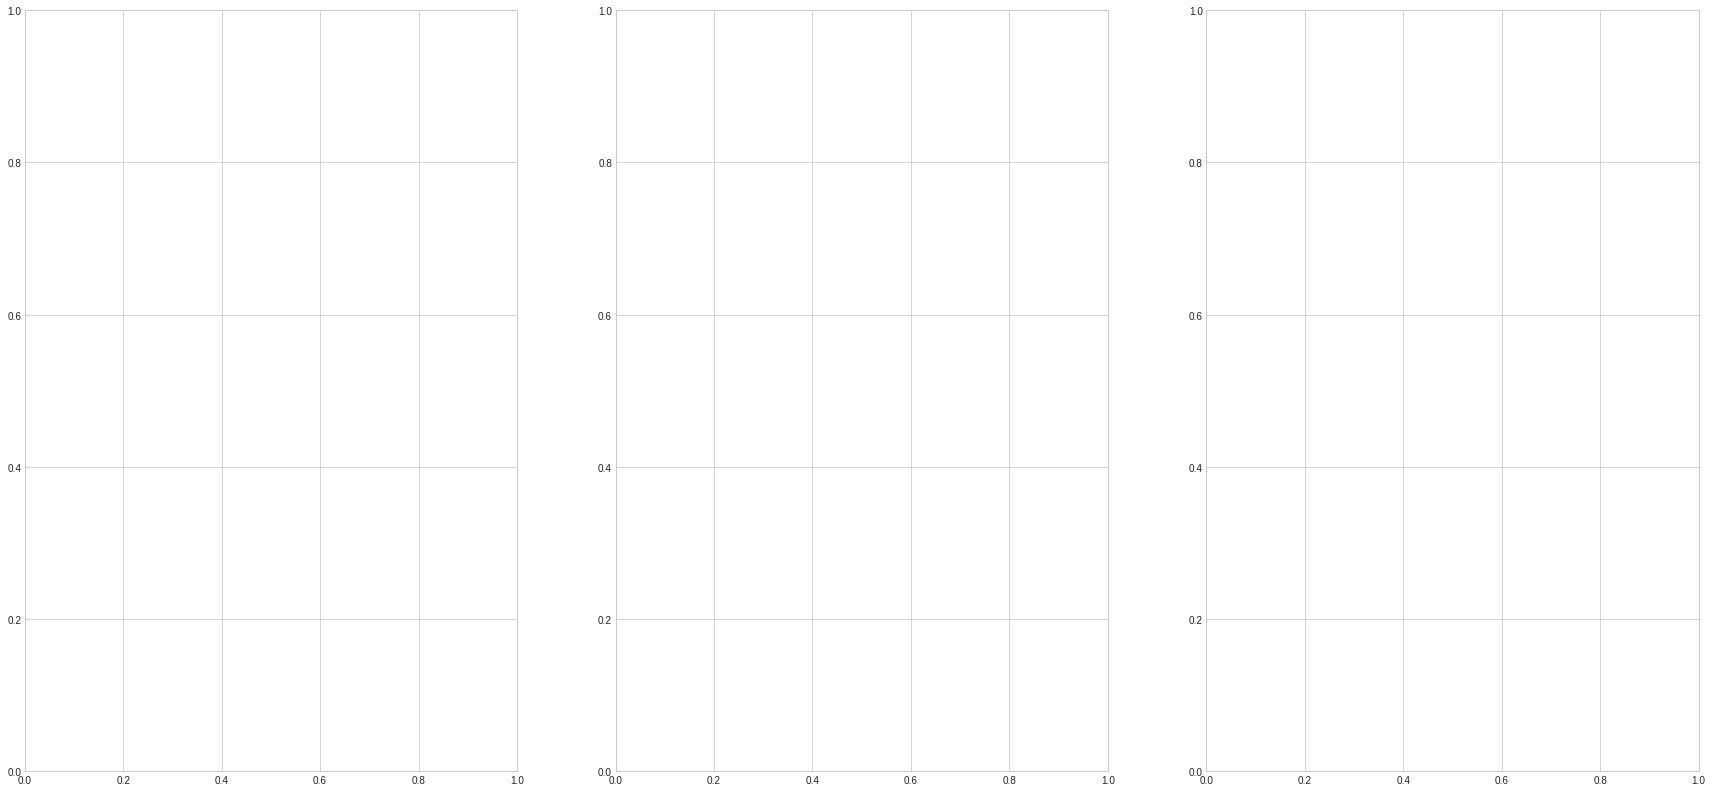

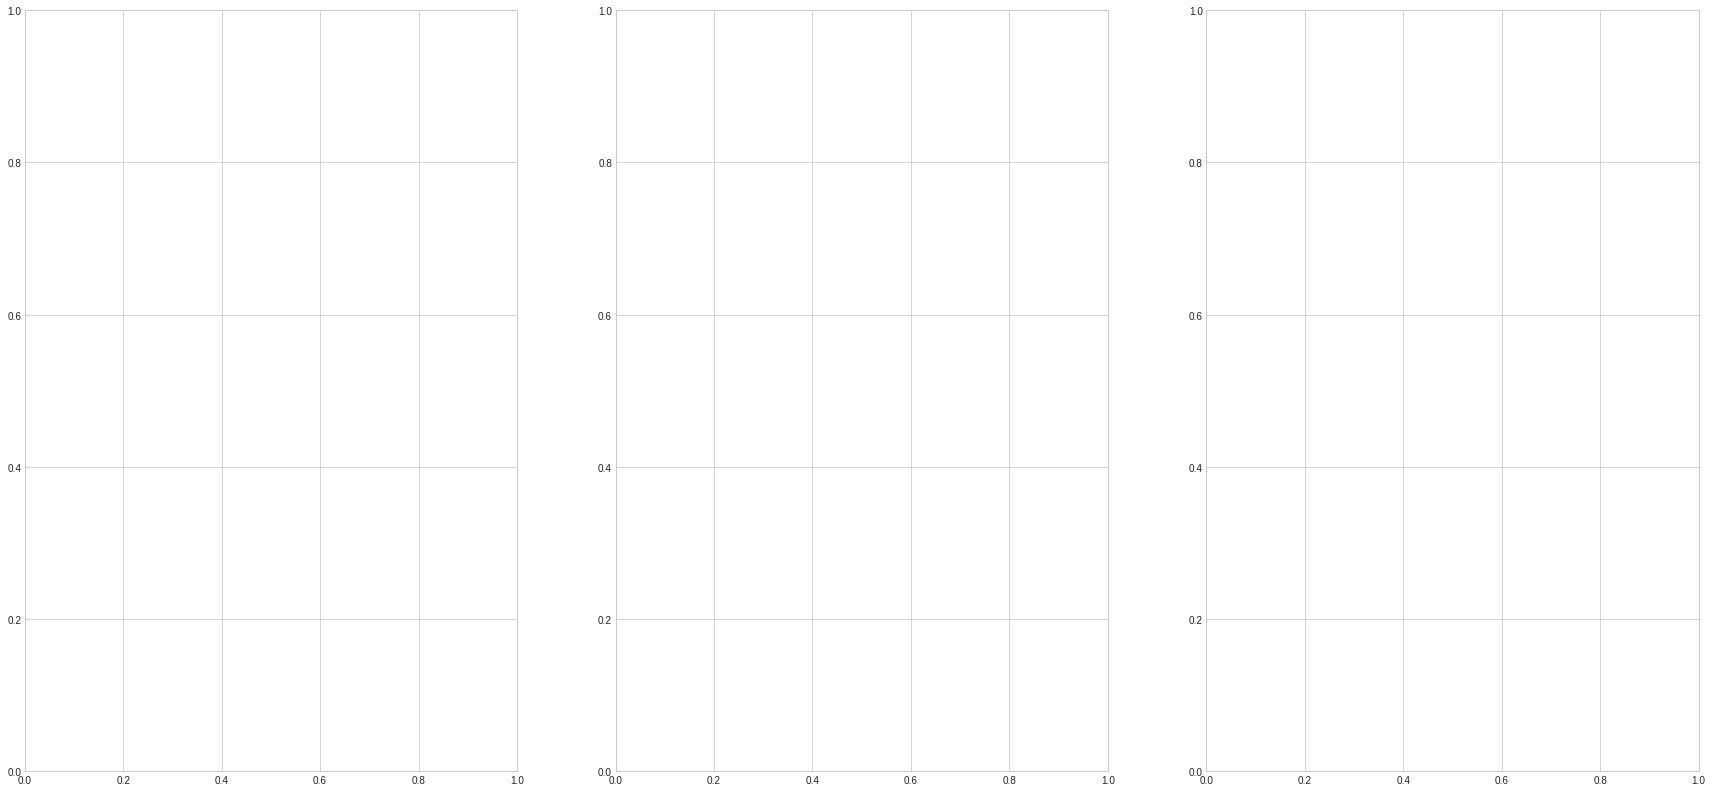

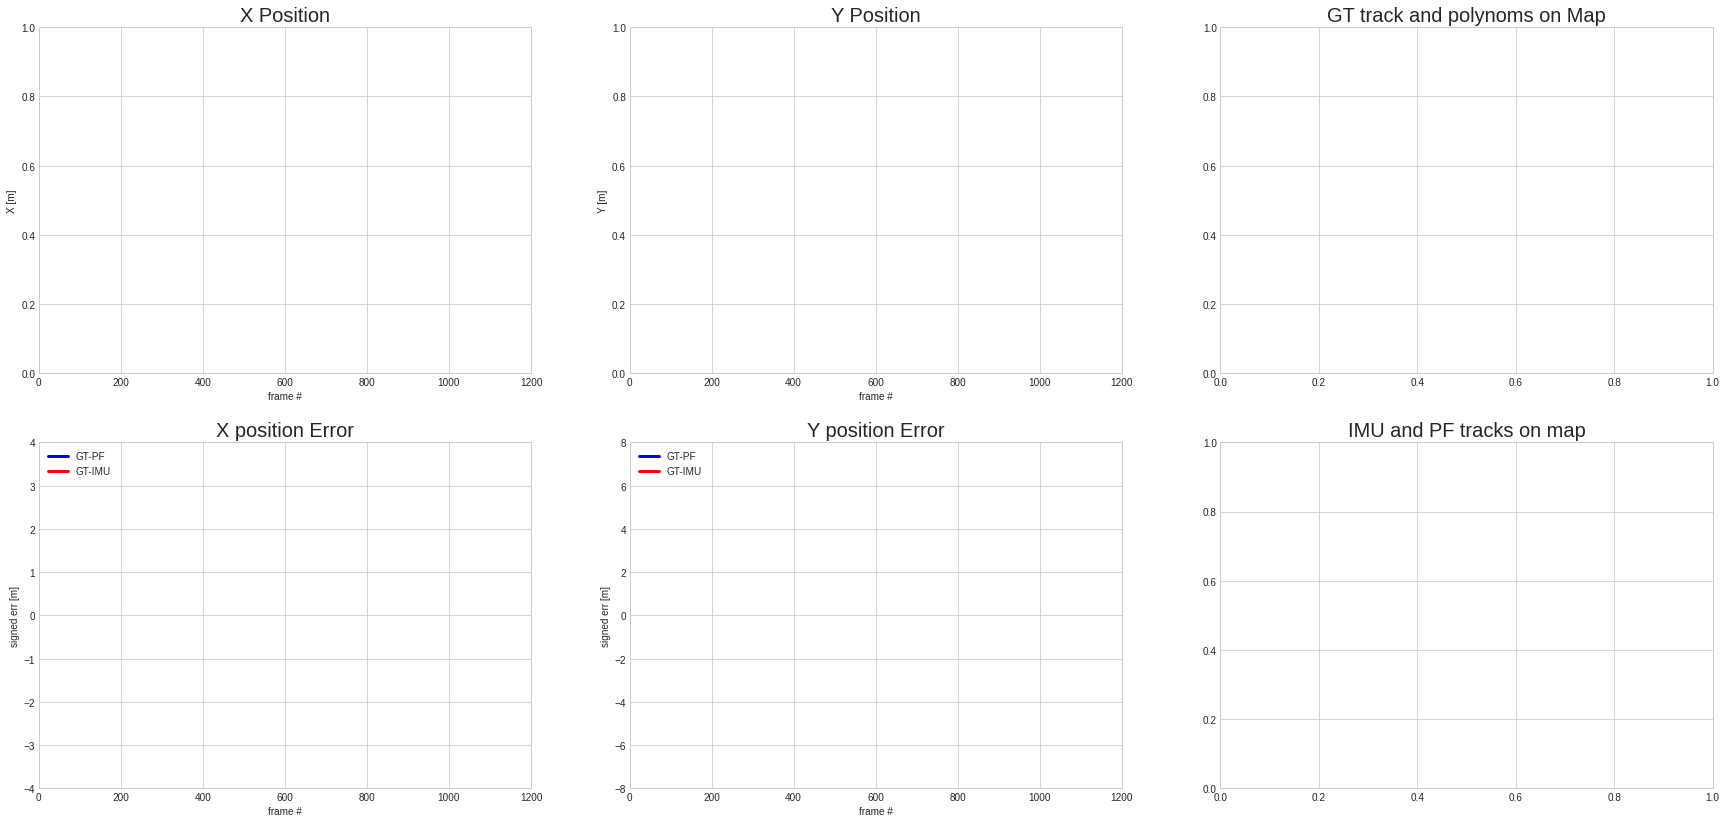

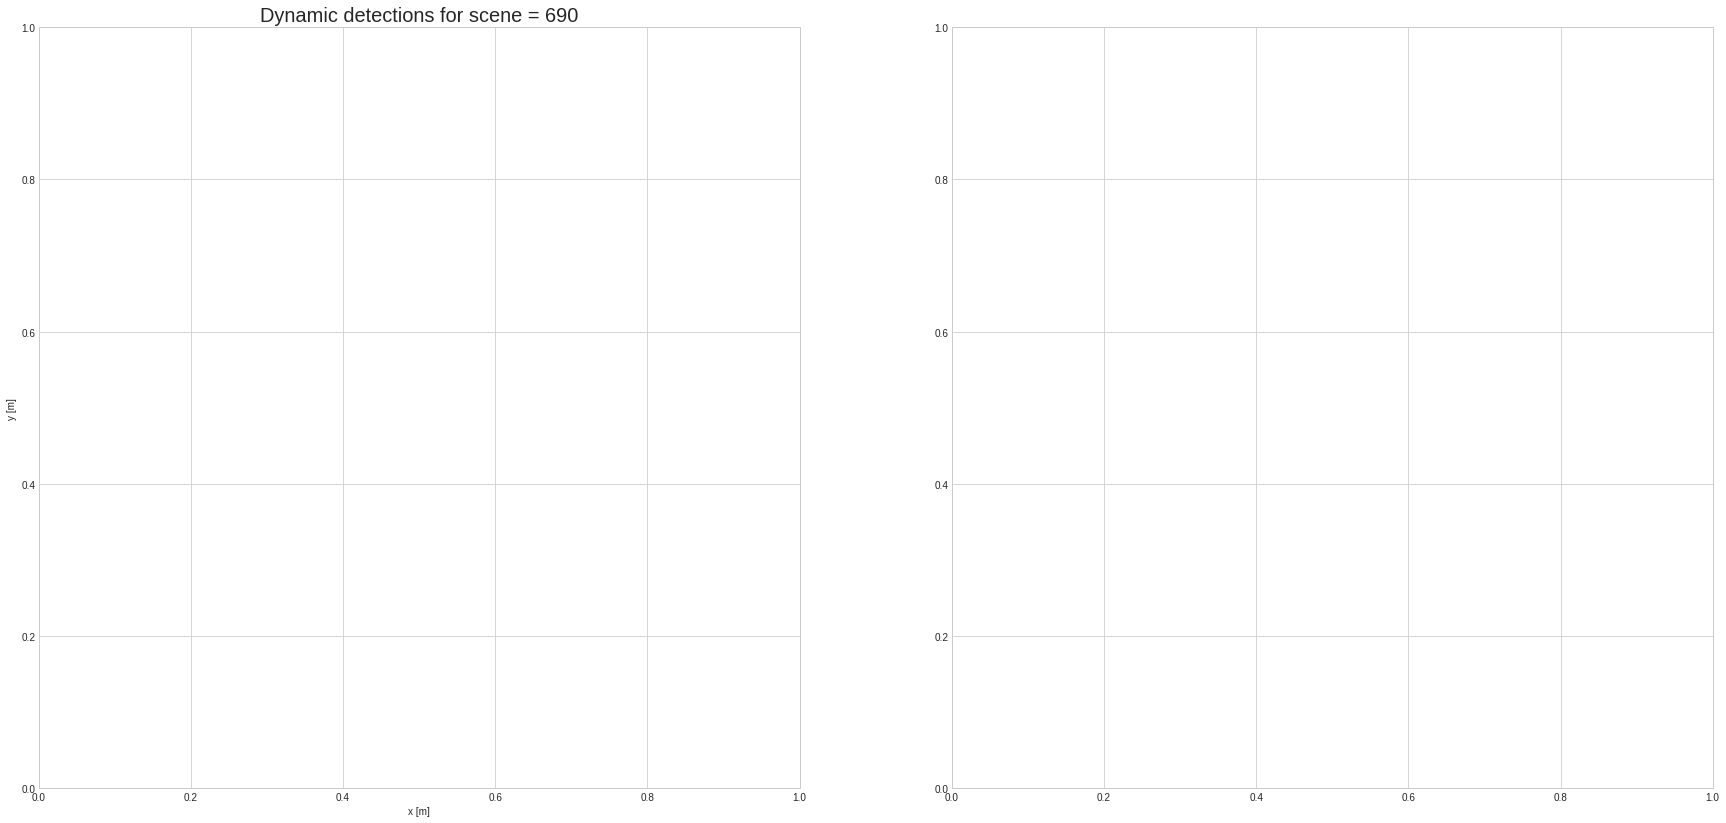

In [2]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 690
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)

In [3]:
from tqdm import tqdm
import math

def calcTrackPosition(ego_path, ego_trns, gt_pos, pf_pos, imu_pos):
    #GT position
    gt_cross_track = 0
    it = np.argmin(np.linalg.norm(ego_path - np.array(gt_pos),axis=1),axis=0)
    it = max(1, min(it, ego_trns.shape[0]-2))
    gt_along_track = np.copy(ego_trns[it])
    #PF position
    it = np.argmin(np.linalg.norm(ego_path - np.array(pf_pos),axis=1),axis=0)
    it = max(1, min(it, ego_path.shape[0]-2))
    x,y,x1,y1,x2,y2 = pf_pos[0],pf_pos[1],ego_path[it-1][0], ego_path[it-1][1], ego_path[it+1][0], ego_path[it+1][1]
    d=(x-x1)*(y2-y1)-(y-y1)*(x2-x1)
    pf_cross_track = np.sign(d) * np.linalg.norm(ego_path[it]-pf_pos) #np.linalg.norm(np.cross(p2-p1, p1-pf_pos))/np.linalg.norm(p2-p1)
    pf_along_track = np.copy(ego_trns[it])
    #IMU position
    it = np.argmin(np.linalg.norm(ego_path - np.array(imu_pos),axis=1),axis=0)
    it = max(1, min(it, ego_path.shape[0]-2))
    x,y,x1,y1,x2,y2 = imu_pos[0],imu_pos[1],ego_path[it-1][0], ego_path[it-1][1], ego_path[it+1][0], ego_path[it+1][1]
    d=(x-x1)*(y2-y1)-(y-y1)*(x2-x1)
    imu_cross_track = np.sign(d) * np.linalg.norm(ego_path[it]-imu_pos)
    imu_along_track = np.copy(ego_trns[it])

    return np.array([gt_cross_track, gt_along_track]), np.array([pf_cross_track, pf_along_track]), np.array([imu_cross_track, imu_along_track])
    

def calc_rmse(ego_path, ego_trns, gt_pos, pf_mean_pos, imu_pos):
    gt_track_pos, pf_track_pos, imu_track_pos = calcTrackPosition(ego_path, ego_trns, gt_pos[0:2], pf_mean_pos, imu_pos)
    pf_track_errors = pf_track_pos - gt_track_pos
    imu_track_errors = imu_track_pos - gt_track_pos

    return pf_track_errors, imu_track_errors
    
def calc_acc_rmse(ego_path, ego_trns, pf_mean_pos, imu_pos, N):
    pf_rmse_lateral = np.zeros(N)
    pf_rmse_longitudal = np.zeros(N)
    imu_rmse_lateral = np.zeros(N)
    imu_rmse_longitudal = np.zeros(N)
    for i in tqdm(range(0,N)):
        pf_track_errors, imu_track_errors = calc_rmse(ego_path, ego_trns, ego_path[i,:], pf_mean_pos[i,:], imu_pos[i,:])
        print("pf_track_errors",pf_track_errors,"imu_track_errors",imu_track_errors)
        pf_rmse_lateral[i] = pf_track_errors[0]
        pf_rmse_longitudal[i] = pf_track_errors[1]
        imu_rmse_lateral[i] = imu_track_errors[0]
        imu_rmse_longitudal[i] = imu_track_errors[1]

    print(f"PF RMSE lateral: {math.sqrt((1. / N) * np.sum(pf_rmse_lateral**2))}")
    print(f"PF RMSE longitudal: {math.sqrt((1. / N) * np.sum(pf_rmse_longitudal**2))}")
    print(f"IMU RMSE lateral: {math.sqrt((1. / N) * np.sum(imu_rmse_lateral**2))}")
    print(f"IMU RMSE longitudal: {math.sqrt((1. / N) * np.sum(imu_rmse_longitudal**2))}")

In [6]:
from database import NuscenesProcessedDatabase
from tqdm import tqdm
data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

for t in tqdm(range(0,1600)):
    img = sim.dataset.getSyncedImage(t)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    video_data["img"] = img

    sim.video_list["video"] = False
    sim.video_list["video_debug"] = False
    sim.video_list["video_pf"] = True
    sim.video_list["video_pf_xy"] = False
    sim.video_list["dynamic_tracker"] = False

    sim.drawPlots(t, video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, nusc_map, video_with_priors, translation, debug_info)

  0%|          | 0/1600 [00:00<?, ?it/s]

self.dir_name images/690/database


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


PF RMSE lateral: 0.009227739324706257
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0


No handles with labels found to put in legend.
  0%|          | 1/1600 [00:01<28:39,  1.08s/it]

PF RMSE lateral: 0.017176686852787965
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.02171067652532841
IMU RMSE longitudal: 0.0


  0%|          | 2/1600 [00:01<26:49,  1.01s/it]

PF RMSE lateral: 0.02294890984060075
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.027757738745457804
IMU RMSE longitudal: 0.0


  0%|          | 3/1600 [00:02<25:49,  1.03it/s]

PF RMSE lateral: 0.0224337732865693
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.027413251335032907
IMU RMSE longitudal: 0.0


  0%|          | 4/1600 [00:03<25:24,  1.05it/s]

PF RMSE lateral: 0.024691703910546422
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.029529742116786717
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.023155440889493, 2.1514800009056922, 4.040756014169736] cost_mean [0.8544664520810241, 1.6537949257761768, 5.974231078490162]


  0%|          | 5/1600 [00:04<26:37,  1.00s/it]

PF RMSE lateral: 0.026046980097451936
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03070753025334861
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0020224796785435, 2.2548103243186066, 4.05725069072068, 4.3429825905564785] cost_mean [0.7849820802992774, 1.729926122113848, 5.968445772012887, 6.216575541141634]


  0%|          | 6/1600 [00:05<27:39,  1.04s/it]

PF RMSE lateral: 0.025566954004324287
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03031527114418411
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9340370493442494, 2.1040401699000815, 5.378959301107649, 6.338397548167134] cost_mean [0.7180793071650746, 1.6675853837839418, 9.10854755728931, 8.395388349808007]


  0%|          | 7/1600 [00:07<28:48,  1.09s/it]

PF RMSE lateral: 0.027991133045655658
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03224235325906929
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8320252883581508, 1.7723385774946148, 5.4205931697359615, 6.530357891595521] cost_mean [0.6274390298710185, 1.4169096921174729, 10.014922344668703, 8.612910831371638]


  0%|          | 8/1600 [00:08<29:37,  1.12s/it]

PF RMSE lateral: 0.03874496598599356
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04318114635978887
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8782055472358312, 1.806204527632031, 4.3976489989416105, 5.257711080916711] cost_mean [0.6714267548247217, 1.392901621205734, 6.388200012819145, 7.078610207268912]


  1%|          | 9/1600 [00:09<30:22,  1.15s/it]

PF RMSE lateral: 0.03726500201809639
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0416209601538915
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9021967781021833, 2.0246919858645818, 4.4204888994637885, 5.139433508440364] cost_mean [0.7060356792071988, 1.525962274608141, 6.4071459320783335, 6.950471994491995]


  1%|          | 10/1600 [00:10<31:06,  1.17s/it]

PF RMSE lateral: 0.03644905521358097
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04031906440246671
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6473083107472195, 1.956293466639262, 4.396140594729649, 5.232042621552567] cost_mean [0.5851869289823095, 1.495465736074659, 6.377430081139435, 7.061720072739715]


  1%|          | 11/1600 [00:12<32:10,  1.21s/it]

PF RMSE lateral: 0.036052598489097316
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03940303192164037
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0561615626592664, 2.1228093205989835, 4.548682461642528, 5.231200785960062] cost_mean [0.8885088280734378, 1.6318963996711964, 6.593602018514303, 7.703842372283145]


  1%|          | 12/1600 [00:13<33:50,  1.28s/it]

PF RMSE lateral: 0.037678925861381975
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04044716002425878
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0478363799941368, 2.146271379419486, 5.199860722183469, 5.948116765739468] cost_mean [0.7988880701288853, 1.8032155920605848, 7.5783305949303665, 12.322008055421913]


  1%|          | 13/1600 [00:14<34:52,  1.32s/it]

PF RMSE lateral: 0.038701948288645
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04111086149207703
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0525320781923322, 1.730117451343796, 5.194416884424571, 5.951309334628379] cost_mean [0.8343471060293594, 1.6280039211474309, 7.956571825613494, 13.772083940246665]


  1%|          | 14/1600 [00:16<35:16,  1.33s/it]

PF RMSE lateral: 0.04083665541408013
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04224894063442803
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8968049897252581, 1.8939386598208534, 5.1891567445642375, 5.962455588420685] cost_mean [0.6964903915871815, 1.4164183034636653, 8.558738099947247, 7.922529455525275]
n_tracks 1 cost_dyn_true [3.8603568411949354] cost_dyn_mean [4.717342112776263]
abs_vel =[6.11159991]
xlim [1134.3062632267572, 1139.4511165057859] ylim [1575.688683078875, 1578.4702189207512]
abs_vel =[6.11159991]


  1%|          | 15/1600 [00:18<40:11,  1.52s/it]

PF RMSE lateral: 0.04032460034650986
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04138010782886744
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.0543257428218327, 5.0285442805121985] cost_mean [0.8495600950781931, 6.749260943946576]
n_tracks 1 cost_dyn_true [3.174358609949956] cost_dyn_mean [4.000336056425381]
abs_vel =[6.13661083]
xlim [1135.4313629222477, 1139.8050467480853] ylim [1575.462608356746, 1578.0275920530673]
abs_vel =[6.13661083]


  1%|          | 16/1600 [00:20<43:49,  1.66s/it]

PF RMSE lateral: 0.03950135117476635
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04024348140664459
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.9794971818597696, 17.861341543464412] cost_mean [0.7893285958072069, 21.76016044786497]
n_tracks 1 cost_dyn_true [3.1501786429659977] cost_dyn_mean [3.9879176913288177]
abs_vel =[6.16512053]
xlim [1135.7152488683387, 1140.2167408171806] ylim [1575.2203046206218, 1577.830926334071]
abs_vel =[6.16512053]


  1%|          | 17/1600 [00:22<46:32,  1.76s/it]

PF RMSE lateral: 0.03928304961502889
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.039928910127649965
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.9329358315977279, 20.94293633346637, 5.199184927304992] cost_mean [0.730945588255182, 25.644368226632707, 7.053058030478891]
n_tracks 1 cost_dyn_true [3.1035929172291166] cost_dyn_mean [3.9208764109376153]
abs_vel =[6.20010019]
xlim [1136.0598199287813, 1141.088564052499] ylim [1574.71627998167, 1577.62705879075]
abs_vel =[6.20010019]


  1%|          | 18/1600 [00:24<48:44,  1.85s/it]

PF RMSE lateral: 0.038535668704518786
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.039107620804289235
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.8301628988702792, 23.167348091035812, 6.209797718106602] cost_mean [0.7887412016360685, 27.452524014538092, 8.186948927477463]
n_tracks 1 cost_dyn_true [3.1446459935370807] cost_dyn_mean [4.0104833418190236]
abs_vel =[6.23638003]
xlim [1136.5324816586935, 1141.5289155224134] ylim [1574.4638144126127, 1577.2835676016125]
abs_vel =[6.23638003]


  1%|          | 19/1600 [00:26<50:47,  1.93s/it]

PF RMSE lateral: 0.04230706721877598
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03831797764831773
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.945286995088783, 18.839730034824168, 5.9742590065568635] cost_mean [0.8186625421832087, 22.225105964800314, 7.860190905019507]
n_tracks 1 cost_dyn_true [2.775767471828333] cost_dyn_mean [3.3783109874323376]
abs_vel =[6.27481604]
xlim [1136.911700626001, 1142.0106015969948] ylim [1574.1723987641979, 1577.0375096319533]
abs_vel =[6.27481604]


  1%|▏         | 20/1600 [00:28<52:11,  1.98s/it]

PF RMSE lateral: 0.050925627638607494
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03792466311690032
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8669238811699089, 27.195477844791526, 5.99002079970782, 17.364800804403192] cost_mean [0.7426556966373474, 30.328162813066875, 7.8819018216728765, 13.66359952920078]
n_tracks 2 cost_dyn_true [1.4818920708797445, 2.4035505765212255] cost_dyn_mean [1.3476399994813386, 3.0276695171432983]
abs_vel =[4.7362435]
abs_vel =[6.31401922]
xlim [1126.4682061961576, 1142.9985084398836] ylim [1573.4161887367363, 1586.1142697775247]
abs_vel =[4.7362435]
abs_vel =[6.31401922]


  1%|▏         | 21/1600 [00:30<53:25,  2.03s/it]

PF RMSE lateral: 0.06035324154339785
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.037333031171021436
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9359926248591812, 22.25485230283001, 6.00985767937219, 13.849596610874515] cost_mean [0.718856586938014, 24.775321544110216, 7.974701073091955, 10.00686719498019]
n_tracks 2 cost_dyn_true [1.4434355683746363, 2.310631894185806] cost_dyn_mean [1.4064189522346098, 2.8411723191962586]
abs_vel =[4.78887681]
abs_vel =[6.35298846]
xlim [1126.7739531106201, 1143.459728033529] ylim [1573.1103850288212, 1585.995054138838]
abs_vel =[4.78887681]
abs_vel =[6.35298846]


  1%|▏         | 22/1600 [00:32<54:44,  2.08s/it]

PF RMSE lateral: 0.06801616106545401
PF RMSE longitudal: 0.06883983533473755
IMU RMSE lateral: 0.037308445983750015
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.102015328750915, 18.54905141025662, 5.11092700141239, 13.353048116260583] cost_mean [0.8315546052912773, 20.26248463763739, 6.775631915252613, 9.894318623601306]
n_tracks 2 cost_dyn_true [1.431038904470507, 2.120837545142395] cost_dyn_mean [1.3483190053632241, 2.7433260441995033]
abs_vel =[4.83959055]
abs_vel =[6.3914047]
xlim [1127.1443034481283, 1143.8984666927547] ylim [1572.7800316771843, 1585.8392962818705]
abs_vel =[4.83959055]
abs_vel =[6.3914047]


  1%|▏         | 23/1600 [00:35<55:53,  2.13s/it]

PF RMSE lateral: 0.08660345692151845
PF RMSE longitudal: 0.06739041331581003
IMU RMSE lateral: 0.0385583347819589
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.1524873505675008, 11.512484626022045, 4.91213661082307, 14.564160123922482] cost_mean [0.9214871530851944, 12.253282522431492, 6.514050466898796, 10.07469226511658]
n_tracks 2 cost_dyn_true [1.4070026675954066, 2.002715677262752] cost_dyn_mean [1.3856629506057248, 2.5900663914824142]
abs_vel =[4.8899207]
abs_vel =[6.43426531]
xlim [1127.4499161347765, 1144.9412948039371] ylim [1572.165595409101, 1585.7102476652688]
abs_vel =[4.8899207]
abs_vel =[6.43426531]


  2%|▏         | 24/1600 [00:37<56:54,  2.17s/it]

PF RMSE lateral: 0.08738379114119448
PF RMSE longitudal: 0.09549654686809843
IMU RMSE lateral: 0.03885173515790452
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9763038566139507, 22.421172841139434, 6.898028551236099, 13.681707457610537] cost_mean [0.8179677417585477, 22.6862473742282, 8.811358751555758, 9.139954352543903]
n_tracks 2 cost_dyn_true [1.3797381155160522, 1.9150931514260432] cost_dyn_mean [1.449372327896086, 2.3966914534544737]
abs_vel =[4.93885153]
abs_vel =[6.47716638]
xlim [1128.0110552885005, 1145.429428313522] ylim [1571.8688198823102, 1585.4462899533628]
abs_vel =[4.93885153]
abs_vel =[6.47716638]


  2%|▏         | 25/1600 [00:39<57:48,  2.20s/it]

PF RMSE lateral: 0.08844994462118747
PF RMSE longitudal: 0.11410398145928104
IMU RMSE lateral: 0.03962638649215341
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8201622616150991, 18.475064348425033, 5.6531137000307865, 10.89719247436817] cost_mean [0.7218368024537865, 18.420754255523363, 7.331969202815674, 6.916141294037446]
n_tracks 2 cost_dyn_true [1.373892570108263, 1.7100095993537843] cost_dyn_mean [1.5132194759987523, 2.125001182657836]
abs_vel =[4.98591346]
abs_vel =[6.52034658]
xlim [1128.460951227582, 1145.8819899308396] ylim [1571.4782031850834, 1585.1755181405777]
abs_vel =[4.98591346]
abs_vel =[6.52034658]


  2%|▏         | 26/1600 [00:41<58:32,  2.23s/it]

PF RMSE lateral: 0.08916499541660396
PF RMSE longitudal: 0.12910320605447817
IMU RMSE lateral: 0.03954775583391366
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9158049510202776, 19.056826180145386, 5.671780933452258, 11.262813875574912] cost_mean [0.7539199439915479, 18.867478199167135, 7.367787658949075, 6.892499113796377]
n_tracks 2 cost_dyn_true [1.3529233836836048, 1.5177661115650174] cost_dyn_mean [1.5293698544199437, 1.9323195164499358]
abs_vel =[5.03107534]
abs_vel =[6.56159512]
xlim [1129.2359334864395, 1146.3417124320076] ylim [1571.168935729129, 1584.7436766888277]
abs_vel =[5.03107534]
abs_vel =[6.56159512]


  2%|▏         | 27/1600 [00:44<59:17,  2.26s/it]

PF RMSE lateral: 0.09142100585016263
PF RMSE longitudal: 0.1422547552367103
IMU RMSE lateral: 0.03976274748021918
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.9028383691657301, 5.663853156365388, 15.258760486454435] cost_mean [0.7674761681658009, 7.402238883436697, 9.45961075954968]
n_tracks 2 cost_dyn_true [1.2749010088436785, 1.393937788153142] cost_dyn_mean [1.4977284749748443, 1.8097986367498582]
abs_vel =[5.07418227]
abs_vel =[6.60268532]
xlim [1129.6284310571864, 1146.8339400435984] ylim [1570.8501048596609, 1584.4830940610375]
abs_vel =[5.07418227]
abs_vel =[6.60268532]


  2%|▏         | 28/1600 [00:46<1:00:02,  2.29s/it]

PF RMSE lateral: 0.10235405687687142
PF RMSE longitudal: 0.1899830666113209
IMU RMSE lateral: 0.039890200724535786
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.878915284596961, 9.769989778033878, 2.709877112560597] cost_mean [0.6826973931460555, 4.929674406799298, 2.241109365382322]
n_tracks 2 cost_dyn_true [1.1207136400697422, 1.352554968743339] cost_dyn_mean [1.2990271004880332, 1.759317076192504]
abs_vel =[5.1143175]
abs_vel =[6.64533549]
xlim [1129.9923811183055, 1147.847518634201] ylim [1570.2274571400212, 1584.193216134734]
abs_vel =[5.1143175]
abs_vel =[6.64533549]


  2%|▏         | 29/1600 [00:49<1:00:32,  2.31s/it]

PF RMSE lateral: 0.10528046117400933
PF RMSE longitudal: 0.1973073226973189
IMU RMSE lateral: 0.04047905741896657
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.9645022488314112, 14.007242000874268, 2.5598933887695217] cost_mean [0.8061608036219818, 8.402067052998799, 2.192200240179236]
n_tracks 2 cost_dyn_true [0.9137486264431757, 1.3453471014127447] cost_dyn_mean [1.045932182944036, 1.7557233867842224]
abs_vel =[5.15507866]
abs_vel =[6.68736697]
xlim [1130.3450105761513, 1148.3555541023964] ylim [1569.9289270269783, 1583.917499671426]
abs_vel =[5.15507866]
abs_vel =[6.68736697]


  2%|▏         | 30/1600 [00:51<1:01:04,  2.33s/it]

PF RMSE lateral: 0.10806050958807462
PF RMSE longitudal: 0.2063423565250882
IMU RMSE lateral: 0.04102010937157903
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.8517679852402095, 10.394213629410775, 2.37504006345844] cost_mean [0.7623621046931415, 5.302833426844893, 1.9035748773816261]
n_tracks 2 cost_dyn_true [0.6969291306545237, 1.3276496871526984] cost_dyn_mean [0.7936700902079381, 1.721403976727153]
abs_vel =[5.19529648]
abs_vel =[6.72853494]
xlim [1130.7656542499435, 1148.896276893349] ylim [1569.5698433120924, 1583.5057114794001]
abs_vel =[5.19529648]
abs_vel =[6.72853494]


  2%|▏         | 31/1600 [00:53<1:01:39,  2.36s/it]

PF RMSE lateral: 0.1097112170541027
PF RMSE longitudal: 0.21294871494231224
IMU RMSE lateral: 0.041208511766635585
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.935900793238502, 2.2347574100964755] cost_mean [0.7902920917925006, 1.898584758817729]
n_tracks 3 cost_dyn_true [0.6331007730310109, 1.263299640383261, 1.950428286301275] cost_dyn_mean [0.6082684539302836, 1.7652369614214591, 2.682477110703246]
abs_vel =[5.2345686]
abs_vel =[6.76879187]
abs_vel =[3.02449813]
xlim [1131.1009629169616, 1149.3986753152267] ylim [1569.0984913194884, 1585.6990360318728]
abs_vel =[5.2345686]
abs_vel =[6.76879187]
abs_vel =[3.02449813]


  2%|▏         | 32/1600 [00:56<1:02:19,  2.39s/it]

PF RMSE lateral: 0.10915576461841113
PF RMSE longitudal: 0.21932156825196414
IMU RMSE lateral: 0.04200503894994363
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.9629250842402346, 2.5431193248711677] cost_mean [0.8494364810831474, 2.098644447348888]
n_tracks 3 cost_dyn_true [0.6376270196052424, 1.1435115858029692, 1.5224482282428227] cost_dyn_mean [0.5065419459710986, 1.7027994017051344, 2.0686525313382544]
abs_vel =[5.27281716]
abs_vel =[6.80796994]
abs_vel =[3.03077502]
xlim [1131.836884510409, 1149.904467461965] ylim [1568.7789268238605, 1585.6139530671662]
abs_vel =[5.27281716]
abs_vel =[6.80796994]
abs_vel =[3.03077502]


  2%|▏         | 33/1600 [00:58<1:03:04,  2.42s/it]

PF RMSE lateral: 0.10867158047011688
PF RMSE longitudal: 0.2240514654509202
IMU RMSE lateral: 0.04275746265785455
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.8204799484171973, 2.1123007404056517] cost_mean [0.6941450469896215, 1.8473389501407298]
n_tracks 3 cost_dyn_true [0.6669649762375729, 1.110930971497058, 1.562250603031996] cost_dyn_mean [0.47622885828126593, 1.7312683520863512, 2.035337899669328]
abs_vel =[5.30988344]
abs_vel =[6.84607807]
abs_vel =[3.03629566]
xlim [1132.2193527491938, 1150.3929325329516] ylim [1568.4549249188972, 1585.6308898177608]
abs_vel =[5.30988344]
abs_vel =[6.84607807]
abs_vel =[3.03629566]


  2%|▏         | 34/1600 [01:01<1:03:46,  2.44s/it]

PF RMSE lateral: 0.12290954867636084
PF RMSE longitudal: 0.2581982698346686
IMU RMSE lateral: 0.04279524522401979
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.8414133327238033, 2.201320797833953] cost_mean [0.785046213654435, 1.8173796213817215]
n_tracks 3 cost_dyn_true [0.6333840308140628, 1.1300054676890992, 1.5676822521656715] cost_dyn_mean [0.48011501514064236, 1.7272331397791956, 2.0853683780820216]
abs_vel =[5.34763235]
abs_vel =[6.88694538]
abs_vel =[3.04118298]
xlim [1132.5568783957688, 1151.5321824683979] ylim [1567.694087656476, 1585.6458858640815]
abs_vel =[5.34763235]
abs_vel =[6.88694538]
abs_vel =[3.04118298]


  2%|▏         | 35/1600 [01:03<1:04:33,  2.48s/it]

PF RMSE lateral: 0.12146723814650659
PF RMSE longitudal: 0.2630754379778559
IMU RMSE lateral: 0.04303053004002132
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.853848833881882, 2.154036397120467] cost_mean [0.7165296268995317, 1.8460450997466626]
n_tracks 3 cost_dyn_true [0.6903452123630391, 1.1025879288144256, 1.3853561656631612] cost_dyn_mean [0.512978424183124, 1.816762376522374, 1.7519280510824862]
abs_vel =[5.38396958]
abs_vel =[6.92862239]
abs_vel =[3.04553011]
xlim [1132.9306567947644, 1152.102719060608] ylim [1567.3042672462163, 1585.6686637735277]
abs_vel =[5.38396958]
abs_vel =[6.92862239]
abs_vel =[3.04553011]


  2%|▏         | 36/1600 [01:06<1:05:15,  2.50s/it]

PF RMSE lateral: 0.11995598036945121
PF RMSE longitudal: 0.2671709040968186
IMU RMSE lateral: 0.04316025251394236
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.9983492511597424, 2.5510309096006636] cost_mean [0.8586402238186087, 2.0174694594308433]
n_tracks 3 cost_dyn_true [0.8241396994769399, 1.0560864409023645, 1.514233451927335] cost_dyn_mean [0.6245540446309263, 1.7459764264643285, 1.8237096858676072]
abs_vel =[5.41876359]
abs_vel =[6.96845585]
abs_vel =[3.04946154]
xlim [1133.3456869206166, 1152.6500888693633] ylim [1566.9676733827346, 1585.6681088594773]
abs_vel =[5.41876359]
abs_vel =[6.96845585]
abs_vel =[3.04946154]


  2%|▏         | 37/1600 [01:08<1:05:49,  2.53s/it]

PF RMSE lateral: 0.11868329800111556
PF RMSE longitudal: 0.27096696020059985
IMU RMSE lateral: 0.043464895533106125
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.9078781161992174, 2.392407610591923] cost_mean [0.7478959272977369, 1.9860430793958699]
n_tracks 2 cost_dyn_true [1.0060673648897824, 0.9679972400773873] cost_dyn_mean [0.7977186519887818, 1.589357524668068]
abs_vel =[5.45220699]
abs_vel =[7.00656823]
xlim [1134.1577176756273, 1153.144754088886] ylim [1566.7971164391029, 1581.0961568546443]
abs_vel =[5.45220699]
abs_vel =[7.00656823]


  2%|▏         | 38/1600 [01:11<1:06:28,  2.55s/it]

PF RMSE lateral: 0.11730613760787408
PF RMSE longitudal: 0.27356498693404635
IMU RMSE lateral: 0.043827382820217614
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.7969016560806913, 2.0544072808196705] cost_mean [0.6701335309422997, 1.6887816459489293]
n_tracks 2 cost_dyn_true [1.2088927561100733, 0.9032301943357407] cost_dyn_mean [0.9728639132287125, 1.5800050104392107]
abs_vel =[5.48406236]
abs_vel =[7.04304276]
xlim [1134.5952525459497, 1153.6486366376378] ylim [1566.4810696534737, 1580.829091131983]
abs_vel =[5.48406236]
abs_vel =[7.04304276]


  2%|▏         | 39/1600 [01:14<1:06:48,  2.57s/it]

PF RMSE lateral: 0.11606704101401957
PF RMSE longitudal: 0.27681779986456295
IMU RMSE lateral: 0.044323434649008474
IMU RMSE longitudal: 0.0
n_polynoms 1 cost_true [0.8943306063508706] cost_mean [0.7935402647976288]
n_tracks 2 cost_dyn_true [1.2823400880211882, 0.9153132816549742] cost_dyn_mean [1.0395353088756467, 1.5615730337724276]
abs_vel =[5.51476225]
abs_vel =[7.07785573]
xlim [1135.0728861710468, 1154.1702895346837] ylim [1566.1124407601042, 1580.527758274144]
abs_vel =[5.51476225]
abs_vel =[7.07785573]


  2%|▎         | 40/1600 [01:16<1:07:11,  2.58s/it]

PF RMSE lateral: 0.12650279020671648
PF RMSE longitudal: 0.27342113380565164
IMU RMSE lateral: 0.04521209357888793
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.8881364658928597, 1.4066173047307278, 7.3007244933755855] cost_mean [0.7783643485818162, 1.092663875784225, 6.313982341941452]
n_tracks 2 cost_dyn_true [1.508362726379172, 0.9789403157925306] cost_dyn_mean [1.2608762173350012, 1.5872194550650183]
abs_vel =[5.5468794]
abs_vel =[7.11421366]
xlim [1135.428371982494, 1155.323787977338] ylim [1565.3846539759663, 1580.3207067312367]
abs_vel =[5.5468794]
abs_vel =[7.11421366]


  2%|▎         | 40/1600 [01:18<50:44,  1.95s/it]  


KeyboardInterrupt: 

In [5]:
from database import NuscenesProcessedDatabase
import numpy as np

data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = video_data["ego_path"][0:1600,0:2]
ego_trns = video_data["ego_trns"][0:1600]
print("ego_trns.shape", ego_trns.shape)
pf_pos = np.zeros(ego_path.shape)
imu_pos = np.zeros(ego_path.shape)
N = ego_path.shape[0]
for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/690/database
ego_trns.shape (1600,)


 22%|██▏       | 349/1600 [00:00<00:00, 1737.01it/s]

pf_track_errors [-0.21516244  0.        ] imu_track_errors [0. 0.]
pf_track_errors [-0.02247056  0.        ] imu_track_errors [0.03070353 0.        ]
pf_track_errors [-0.03146236  0.        ] imu_track_errors [0.03699688 0.        ]
pf_track_errors [-0.020812  0.      ] imu_track_errors [0.02635278 0.        ]
pf_track_errors [-0.03217615  0.        ] imu_track_errors [0.03679787 0.        ]
pf_track_errors [-0.03197295  0.        ] imu_track_errors [0.03602341 0.        ]
pf_track_errors [-0.02247249  0.        ] imu_track_errors [0.02784592 0.        ]
pf_track_errors [-0.04113811  0.        ] imu_track_errors [0.04339868 0.        ]
pf_track_errors [-0.08510302  0.        ] imu_track_errors [-0.09200515  0.        ]
pf_track_errors [-0.01939722  0.        ] imu_track_errors [-0.02327103  0.        ]
pf_track_errors [-0.02696416  0.        ] imu_track_errors [-0.02364008  0.        ]
pf_track_errors [-0.03136253  0.        ] imu_track_errors [-0.02737317  0.        ]
pf_track_errors 

 43%|████▎     | 691/1600 [00:00<00:00, 1722.55it/s]

pf_track_errors [0.30023935 1.64220344] imu_track_errors [-2.68827205  2.19003157]
pf_track_errors [0.24900257 1.63560312] imu_track_errors [-2.68907988  2.1867094 ]
pf_track_errors [0.26058041 1.685194  ] imu_track_errors [-2.69639299  2.24676398]
pf_track_errors [0.28825559 1.69893585] imu_track_errors [-2.70035162  2.27062542]
pf_track_errors [0.27375582 1.71951914] imu_track_errors [-2.72875701  1.71951914]
pf_track_errors [0.42445458 1.13325955] imu_track_errors [-2.7017489   2.25383739]
pf_track_errors [0.26962014 1.69226741] imu_track_errors [-2.70588669  2.26741761]
pf_track_errors [0.25483779 1.69572804] imu_track_errors [-2.70608923  2.27458116]
pf_track_errors [0.26238396 1.7294898 ] imu_track_errors [-2.71203066  2.31105325]
pf_track_errors [0.303496   1.73590305] imu_track_errors [-2.71527049  2.30732904]
pf_track_errors [0.27668107 1.72847592] imu_track_errors [-2.71777066  2.31603717]
pf_track_errors [0.31723193 1.74055069] imu_track_errors [-2.75112703  1.74055069]
pf_t

 65%|██████▍   | 1036/1600 [00:00<00:00, 1722.13it/s]

pf_track_errors [-3.8958636   2.84996457] imu_track_errors [-5.93090982 -0.93652279]
pf_track_errors [-3.87907442  2.891481  ] imu_track_errors [-5.89365005 -1.40362378]
pf_track_errors [-3.87728581  2.90949442] imu_track_errors [-5.87924132 -0.93955186]
pf_track_errors [-3.86925157  2.93249634] imu_track_errors [-5.83389519 -1.41155416]
pf_track_errors [-3.85279354  2.93923401] imu_track_errors [-5.80267613 -1.4322957 ]
pf_track_errors [-3.82888218  2.9963245 ] imu_track_errors [-5.75098678 -1.91041271]
pf_track_errors [-3.83692544  2.99756067] imu_track_errors [-5.72888168 -1.94702783]
pf_track_errors [-3.84544005  3.01903706] imu_track_errors [-5.70506916 -1.94964959]
pf_track_errors [-3.84536044  3.07395654] imu_track_errors [-5.68765194 -1.49408593]
pf_track_errors [-3.83848088  2.57937633] imu_track_errors [-5.65807078 -1.98866613]
pf_track_errors [-3.80702491  2.62355368] imu_track_errors [-5.61826765 -1.99724279]
pf_track_errors [-3.81532452  3.16576133] imu_track_errors [-5.60

 86%|████████▌ | 1376/1600 [00:00<00:00, 1709.02it/s]

pf_track_errors [-3.13738965  1.16614136] imu_track_errors [-5.75973005 -1.73298486]
pf_track_errors [-3.14548937  1.16159836] imu_track_errors [-5.75937934 -1.16737575]
pf_track_errors [-3.18851633  1.74838225] imu_track_errors [-5.7666833  -1.16614136]
pf_track_errors [-3.15071638  1.16968178] imu_track_errors [-5.77344298 -1.16159836]
pf_track_errors [-3.15115825  1.22242798] imu_track_errors [-5.78677738 -1.16968178]
pf_track_errors [-3.14877974  1.22529616] imu_track_errors [-5.80680604 -1.76074443]
pf_track_errors [-3.15278111  1.18971982] imu_track_errors [-5.79990744 -1.22242798]
pf_track_errors [-3.15691917  1.16423298] imu_track_errors [-5.80687539 -1.22529616]
pf_track_errors [-3.22008551  1.77611423] imu_track_errors [-5.81407428 -1.18971982]
pf_track_errors [-3.17242937  1.20767023] imu_track_errors [-5.81716392 -1.16423298]
pf_track_errors [-3.17008     1.25280669] imu_track_errors [-5.82485676 -1.20767023]
pf_track_errors [-3.17802739  1.21614738] imu_track_errors [-5.85

100%|██████████| 1600/1600 [00:00<00:00, 1706.04it/s]

pf_track_errors [-2.99536825 -0.36459346] imu_track_errors [-7.34904617 -0.36459346]
pf_track_errors [-3.02730637  0.        ] imu_track_errors [-7.36390069  0.        ]
pf_track_errors [-3.00272664 -0.36435991] imu_track_errors [-7.36763577  0.        ]
pf_track_errors [-3.00151125 -0.36306522] imu_track_errors [-7.3728457  0.       ]
pf_track_errors [-3.00030219 -0.37289387] imu_track_errors [-7.37647171  0.        ]
pf_track_errors [-3.00239615 -0.38368783] imu_track_errors [-7.37849592  0.        ]
pf_track_errors [-2.99374182 -0.38906597] imu_track_errors [-7.38184458  0.        ]
pf_track_errors [-2.99993368  0.        ] imu_track_errors [-7.38850704  0.        ]
pf_track_errors [-2.9936806 -0.3847618] imu_track_errors [-7.39183999  0.        ]
pf_track_errors [-2.98986226  0.        ] imu_track_errors [-7.39581367  0.        ]
pf_track_errors [-2.98612504 -0.40061473] imu_track_errors [-7.39926462  0.        ]
pf_track_errors [-2.98594459  0.        ] imu_track_errors [-7.403312